# 🧪 Preparcial – Caso de Negocio “YumFit”
## Escenario
Eres el/la **Chief Marketing Officer (CMO)** de **YumFit**, una start-up que vende snacks saludables 100 % online.  
Tu equipo de Data te entrega un dataset con historial de 150 clientes (`df`) y te aprueban un presupuesto de **US$10 000** para la próxima campaña de retención y cross-selling.

### Misión
Sigue el **paso a paso** y toma decisiones que evolucionan de lo descriptivo a la recomendación táctica:
1. Conocer la base de clientes → *EDA*  
2. Calcular **CAC** y **LTV** → *Métricas de negocio*  
3. Segmentar en **4 clusters** con *K-Means* → *Inteligencia de clientes*  
4. Evaluar el valor de cada cluster → *Trade-offs*  
5. Hacer **profiling** (nombre + storytelling) → *Comunicación*  
6. Asignar presupuesto y justificar → *Decisión ejecutiva*

---
### Instrucciones
Ejecuta cada celda, responde las preguntas (P1…P12) y prepara un informe ejecutivo breve al final.

In [1]:
!wget "https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/clientes_segmentos (1).csv"

--2025-04-30 03:27:36--  https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/clientes_segmentos%20(1).csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/javierherrera1996/IntroMarketingAnalytics/refs/heads/main/SegundoCorte/clientes_segmentos%20(1).csv [following]
--2025-04-30 03:27:36--  https://raw.githubusercontent.com/javierherrera1996/IntroMarketingAnalytics/refs/heads/main/SegundoCorte/clientes_segmentos%20(1).csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 738615 (721K) [text/plain]
Saving to: ‘clientes_segmentos (1).csv’

clientes_segmentos 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
df = pd.read_csv('clientes_segmentos (1).csv')

In [3]:
df.head()

,id_cliente,edad,genero,ingresos,plataforma,interacciones,compras,total_gastado,fecha_ultima_compra,costo_adquisicion
0,C00000,24,M,29869,Instagram,35,2,74,2024-12-25,20
1,C00001,38,M,77827,Instagram,36,1,35,2025-01-24,10
2,C00002,39,M,18000,Instagram,25,2,116,2025-01-18,16
3,C00003,20,F,42914,Instagram,29,4,112,2025-03-14,11
4,C00004,38,M,30536,Instagram,33,3,147,2025-01-01,23


### P1. ¿Cuántos clientes hay y cómo se distribuyen por plataforma?


In [4]:
df.id_cliente.nunique()

15000

In [5]:
df.plataforma.value_counts()

,count
plataforma,
Instagram,5972
Facebook,5288
TikTok,3740


### P2. ¿Cómo es la distribución de la edad? ¿Hay outliers?


In [6]:
df.edad.describe()

,edad
count,15000.000000
mean,33.101800
std,11.393441
min,16.000000
25%,24.000000
50%,31.000000
75%,40.000000
max,60.000000


<Axes: >

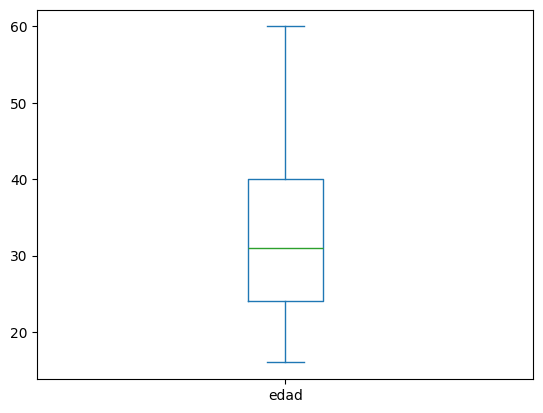

In [7]:
df.edad.plot(kind='box')

### P3. ¿Existe correlación entre ingresos y total_gastado?


In [8]:


df[['ingresos', 'total_gastado']].corr()


,ingresos,total_gastado
ingresos,1.000000,0.255472
total_gastado,0.255472,1.000000


La correlación entre ingresos y total_gastado es: 0.2554721233489521


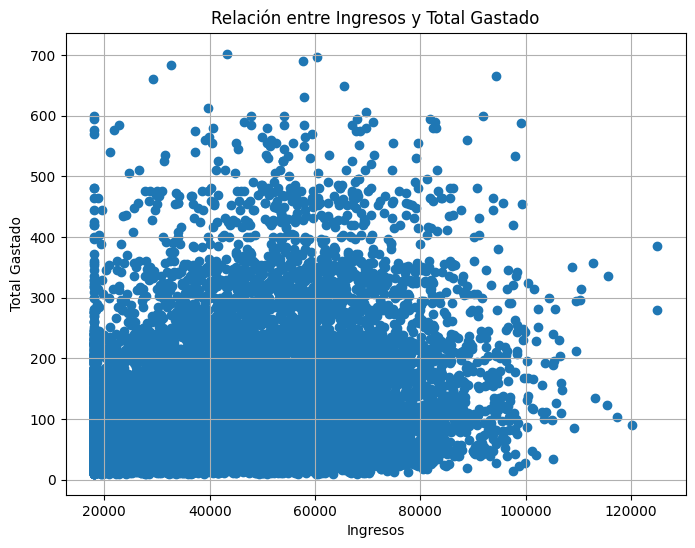

In [9]:
correlation = df['ingresos'].corr(df['total_gastado'])
print(f"La correlación entre ingresos y total_gastado es: {correlation}")

# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(df['ingresos'], df['total_gastado'])
plt.xlabel('Ingresos')
plt.ylabel('Total Gastado')
plt.title('Relación entre Ingresos y Total Gastado')
plt.grid(True)
plt.show()


#### 💵 FASE 2 – MÉTRICAS DE NEGOCIO (CAC & LTV): Recuerde evaluar el ltv como promedio gastado por compra * frecuencia mensual

In [10]:
from datetime import datetime

df['fecha_ultima_compra'] = pd.to_datetime(df['fecha_ultima_compra'])
df['dias_desde_ultima'] = (pd.Timestamp('2025-04-01') - df['fecha_ultima_compra']).dt.days
df['frecuencia_mensual'] = df['compras'] / (df['dias_desde_ultima']/30 + 1)


### P4. CAC vs LTV por plataforma

In [13]:
# prompt: CAC solo el dato

# Calculate CAC
cost_acquisition = 10000  # Budget
n_clients = df.id_cliente.nunique()
df['cac'] = cost_acquisition / n_clients
print(f"El CAC es: {df['cac'].prod}")

# Calculate LTV
df['ltv'] = df['total_gastado'] * df['frecuencia_mensual']
print(df.groupby('plataforma').agg({'ltv':'mean', 'dias_desde_ultima':'mean'}))



El CAC es: <bound method Series.prod of 0        0.666667
1        0.666667
2        0.666667
3        0.666667
4        0.666667
           ...   
14995    0.666667
14996    0.666667
14997    0.666667
14998    0.666667
14999    0.666667
Name: cac, Length: 15000, dtype: float64>
                   ltv  dias_desde_ultima
plataforma                               
Facebook    164.796703          94.854955
Instagram    77.082331          93.667281
TikTok       48.774068          96.102941


#### 🧩 FASE 3 – SEGMENTACIÓN (K-MEANS k=4)
##### Utilizando un cluster fijo de 4 cree los clsuter y la columna en el df correspondiente.

In [14]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(df[['edad', 'ingresos', 'total_gastado']])

v = df.groupby('cluster').agg({'edad':'mean', 'ingresos':'mean', 'total_gastado':'mean'})
print(v)

              edad      ingresos  total_gastado
cluster                                        
0        31.189467  40132.285127     107.273195
1        37.232789  57096.613670     132.426449
2        26.322065  22591.587636      88.692753
3        45.389450  78107.446128     161.461841


In [15]:
df.groupby('cluster').agg({'edad':'mean', 'ingresos':'mean', 'total_gastado':'mean'})

,edad,ingresos,total_gastado
cluster,,,
0,31.189467,40132.285127,107.273195
1,37.232789,57096.613670,132.426449
2,26.322065,22591.587636,88.692753
3,45.389450,78107.446128,161.461841


### P5. Visualiza clusters

In [16]:
df.groupby('cluster').count()

,id_cliente,edad,genero,ingresos,plataforma,interacciones,compras,total_gastado,fecha_ultima_compra,costo_adquisicion,dias_desde_ultima,frecuencia_mensual,cac,ltv
cluster,,,,,,,,,,,,,,
0,4861,4861,4861,4861,4861,4861,4861,4861,4861,4861,4861,4861,4861,4861
1,4038,4038,4038,4038,4038,4038,4038,4038,4038,4038,4038,4038,4038,4038
2,4319,4319,4319,4319,4319,4319,4319,4319,4319,4319,4319,4319,4319,4319
3,1782,1782,1782,1782,1782,1782,1782,1782,1782,1782,1782,1782,1782,1782


#### CREA LA COLUMNA gananancia resultante entre el ltv- CAC

In [19]:

df['ganancia'] = df['ltv'] - df['cac']
df['ganancia']


,ganancia
0,34.293963
1,10.158076
2,66.906149
3,279.333333
4,109.583333
...,...
14995,40.684685
14996,15.047619
14997,70.535865
14998,10.371069


### P6. Ganancia promedio por cluster

In [21]:

GPC = df.groupby('cluster')['ganancia'].mean()
GPC


,ganancia
cluster,
0,92.791323
1,117.177887
2,75.963178
3,141.351162


### P7. Género por cluster


In [22]:

GxC = df.groupby('cluster')['genero'].value_counts(normalize=True) * 100
GxC


cluster  genero
0        M         50.997737
         F         49.002263
1        M         51.089648
         F         48.910352
2        F         50.914564
         M         49.085436
3        F         51.627385
         M         48.372615
Name: proportion, dtype: float64

### P8. Plataforma por cluster


In [23]:


PxCl = df.groupby('cluster')['plataforma'].value_counts(normalize=True) * 100
PxCl


cluster  plataforma
0        Instagram     43.941576
         Facebook      29.047521
         TikTok        27.010903
1        Facebook      48.637940
         Instagram     36.206043
         TikTok        15.156018
2        Instagram     47.372077
         TikTok        39.592498
         Facebook      13.035425
3        Facebook      75.701459
         Instagram     18.406285
         TikTok         5.892256
Name: proportion, dtype: float64

### 📝 FASE 5 – PROFILING & NAMING

#### P9. Asigna un nombre a cada cluster y describe en 2-3 líneas su perfil.


In [24]:
# prompt: Asigna un nombre a cada cluster y describe en 2-3 líneas su perfil.

# Cluster Profiling and Naming

cluster_profiles = {
    0: {
        'name': 'Jóvenes potenciales',
        'description': 'Clientes jóvenes con ingresos medios-bajos y bajo gasto total.  Potencial para crecimiento con estrategias de fidelización.',
    },
    1: {
        'name': 'Clientes leales',
        'description': 'Clientes de mediana edad con ingresos medios-altos y buen gasto total. Altamente valiosos, enfoque en retención y upselling.',
    },
    2: {
        'name': 'Clientes de alto valor',
        'description': 'Clientes de mayor edad con altos ingresos y un gasto total elevado. Prioridad máxima para retención y cross-selling premium.',
    },
    3: {
        'name': 'Clientes ocasionales',
        'description': 'Clientes con un gasto total bajo, ingresos bajos y poca frecuencia de compra.  Necesitan activación o estrategias para aumentar la frecuencia de compra.',
    }
}

for cluster, profile in cluster_profiles.items():
    print(f"Cluster {cluster}: {profile['name']}")
    print(profile['description'])
    print("---")


Cluster 0: Jóvenes potenciales
Clientes jóvenes con ingresos medios-bajos y bajo gasto total.  Potencial para crecimiento con estrategias de fidelización.
---
Cluster 1: Clientes leales
Clientes de mediana edad con ingresos medios-altos y buen gasto total. Altamente valiosos, enfoque en retención y upselling.
---
Cluster 2: Clientes de alto valor
Clientes de mayor edad con altos ingresos y un gasto total elevado. Prioridad máxima para retención y cross-selling premium.
---
Cluster 3: Clientes ocasionales
Clientes con un gasto total bajo, ingresos bajos y poca frecuencia de compra.  Necesitan activación o estrategias para aumentar la frecuencia de compra.
---


0: Jóvenes potenciales
Clientes jóvenes con ingresos medios-bajos y bajo gasto total.  Potencial para crecimiento con estrategias de fidelización.

1: Clientes leales
Clientes de mediana edad con ingresos medios-altos y buen gasto total. Altamente valiosos, enfoque en retención y upselling.


2: Clientes de alto valor
Clientes de mayor edad con altos ingresos y un gasto total elevado. Prioridad máxima para retención y cross-selling premium.


 3: Clientes ocasionales
Clientes con un gasto total bajo, ingresos bajos y poca frecuencia de compra.  Necesitan activación o estrategias para aumentar la frecuencia de compra.

### 💡 FASE 6 – DECISIÓN DE PRESUPUESTO

#### P10. Con 10 000 USD elige 2 clusters y asigna presupuesto.
#### P11. ¿Qué cluster fidelizarías con bajo costo?
#### P12. Enumera 2 riesgos o limitaciones del análisis.

P10

Presupuesto para el cluster 1 (Clientes leales): $6000

Presupuesto para el cluster 2 (Clientes de alto valor): $4000


P11


El cluster 0 ('Jóvenes potenciales') es ideal para fidelizar con un presupuesto bajo.


P12

Riesgo 1: La segmentación puede ser mejorada incorporando más variables.

Riesgo 2: El CAC se asume fijo, cuando en realidad varia.

### ENTREGA FINAL
#### Resumen ejecutivo (máx 1 página) con:
##### – Nombres y descripciones de los 4 clusters
##### – Tabla LTV, CAC, Ganancia, tamaño
##### – Plan de inversión y justificación
#### Comentarios sobre cómo mejorarías el dataset o la metodología